#Resnet50 training with Augmented dataset (iNat)

In this notebook we will be using the iNaturalist API to construct a training dataset for transfer learning. We will be training with 5000 images per species with 26 species. However, we will be experimenting with other image augmentation methods such as Mixup, Cutmix, RandAugment and label smoothing.

This notebook was produced and ran in SageMaker (AWS). It was ran with 1TB or storage (minimum needed is 600GB) and with an instance type of `ml.inf1.24xlarge`
it has 96 CPU cores and 192GB in RAM.

If this notebook is to be ran, please make sure that a suitable notebook instance is chosen and it has CUDA set up and configured. This can be achieved by using this [article](
https://arinzeakutekwe.medium.com/how-to-configure-nvidia-gpu-to-work-with-tensorflow-2-on-aws-sagemaker-1be98b9db464).

#Installations and Setup for SageMaker

In [ ]:
! pip install keras-cv
! pip install tensorrt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar
import time
import keras_cv

# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-07-15 17:57:05.797881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 17:57:07.278292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-15 17:57:09.626419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Using TensorFlow backend


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  0


#Variable Setup

The `SPECIES_TO_RETRIEVE` contains the[ top 50 species of animals ](https://www.zootierliste.de/en/?org=10)that were featured in european zoo and that are also species avaliable in the iNat dataset. It is important to note that many common animals such as: mongoose, meerkat, ring-tailed lemur, llama, alpaca, cockatiel, ball python, two-humped camel, Patagonian mara , silver pheasant, red-footed tortoise, Cotton-top
tamarin, ferret, leopard gecko, gorillas and tigers. Were not avaliable in the dataset.

We will be training with the top 26 species for time-efficiency, this also allows the results to be easily compared to another notebook that uses API images for transfer learning on the same species.



In [ ]:
# List of species names to search for
species_names =  sorted([
                    'pavo_cristatus', #peacock
                    'capra_hircus',   #goat
                    'dama_dama', #european fallow deer
                    'dromaius_novaehollandiae', # emu
                    'cavia_aperea', # brazilian guinea pig
                    'oryctolagus_cuniculus', # european rabbit
                    'melopsittacus_undulatus', # budgerigar
                    'ara_ararauna', # blue and yellow macaw
                    'vicugna_vicugna', # vicuña
                    'lama_guanicoe', # Guanaco
                    'equus_asinus', # donkey
                    'gallus_gallus', # chicken
                    'phasianus_colchicus', # ring-necked pheasant
                    'wallabia_bicolor', # Golden swamp wallaby
                    'testudo_hermanni', # Hermann's tortoise
                    'equus_caballus', # shetland pony
                    'trachemys_scripta', # red-eared slider
                    'procyon_lotor', # north american raccoon
                    'aix_galericulata', # mandarin duck
                    'iguana_iguana', # green iguana
                    'pantherophis_guttatus', # corn snake
                    'struthio_camelus', # common ostrich
                    'bubo_scandiacus', # snowy owl
                    'cygnus_atratus', # black swan
                    'panthera_leo', # lion
                    'bubo_bubo', # Eurasian eagle-owl
                    # 'ciconia_ciconia', # white stork
                    # 'pogona_barbata', # Eastern bearded dragon
                    # 'ara_macao', # south american scarlet macaww
                    # 'ovis_aries', # mouflon
                    # 'nasua_nasua', # south-american coati
                    # 'aix_sponsa', #  wood duck
                    # 'anser_anser', # greylag goose
                    # 'cairina_moschata', # muscovy duck
                    # 'hydrochoerus_hydrochaeris', # capybara
                    # 'dacelo_novaeguineae', # kookaburra
                    # 'cyprinus_rubrofuscus', # koi fish
                    # 'callithrix_penicillata', # black-tufted marmoset
                    # 'lutra_lutra', # otter
                    # 'haliaeetus_leucocephalus', # bald eagle
                    # 'numida_meleagris', # helmeted guineafowl
                    # 'mustela_frenata', # long-tailed weasel
                    # 'anas_platyrhynchos', # mallard duck
                    # 'boa_constrictor', # boa constrictor
                    # 'giraffa_camelopardalis', # giraffe
                    # 'alligator_mississippiensis', # mississippi alligator
                    # 'panthera_onca', # jaguar
                    # 'panthera_pardus', # leopard
                    # 'parabuteo_unicinctus', # desert Hawk
                    # 'puma_concolor', # cougar
                     ])

species_names = [' '.join(s.split('_')) for s in species_names]
# Maximum number of images to download for each species
max_images_per_species = 5000

In [ ]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(180, 180)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.resize(max_size)  # Resize image to the exact specified size

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

#Downloading Images via API

In [ ]:

session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    time.sleep(1)
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/ec2-user/SageMaker/train/{species_name.replace(" ", "_")}'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            time.sleep(0.05)
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/ec2-user/SageMaker/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

In [ ]:
# Count number of images downloaded
path = '/home/ec2-user/SageMaker/train'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

124385


#Load iNaturalist Validation Dataset via inat competition 2021

In [ ]:
dm = tfds.download.DownloadManager(download_dir='/home/ec2-user/SageMaker')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}


##Download

In [ ]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

In [ ]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [ ]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Curating collection of annotated images (Filtering)

In [ ]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [ ]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)

['aix galericulata', 'ara ararauna', 'bubo bubo', 'bubo scandiacus', 'capra hircus', 'cavia aperea', 'cygnus atratus', 'dama dama', 'dromaius novaehollandiae', 'equus asinus', 'equus caballus', 'gallus gallus', 'iguana iguana', 'lama guanicoe', 'melopsittacus undulatus', 'oryctolagus cuniculus', 'panthera leo', 'pantherophis guttatus', 'pavo cristatus', 'phasianus colchicus', 'procyon lotor', 'struthio camelus', 'testudo hermanni', 'trachemys scripta', 'vicugna vicugna', 'wallabia bicolor']


We will get reading from the json file to collect image annotation of species we are interested in. This will later allow us to collect image directories of all the species we are concerned in.

In [ ]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

##Extracting the Images

We will be extracting **all** files from both the validation archive. This is because it is more time efficient than extracting images one by one.


In [ ]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:
  t.extractall('/home/ec2-user/SageMaker')


##Deleting classes

In [ ]:
import os,sys
import shutil

# get directory paths of species we want to train by getting all directory names
# from our extracted validation dataset. Because we didn't download the whole validation dataset
speciesDir = []

for id,value in annotatedFiles.items():
    if value['imagedirectory'] not in speciesDir:
      speciesDir.append(value['imagedirectory'])

# get train_mini extracted dataset path
path = '/home/ec2-user/SageMaker/val'
# get list of directories in val
dirs = os.listdir( path )
for d in dirs:
  # if val directory's name does not match an existing directory in our annotated list
  if d not in speciesDir:
    try:
      # delete species directory
      shutil.rmtree(os.path.join(path, d))
    except:
      print(f'error with directory {os.path.join(path, d)}')


##Resize and renaming

In [ ]:
# rename all folders to match class names of the training dataset
path = '/home/ec2-user/SageMaker/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{('_'.join(folder.split('_')[6::])).lower()}")

  # get path of each image in class folder
  new_path = f"{path}/{('_'.join(folder.split('_')[6::])).lower()}"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((180,180))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

Quick check

In [ ]:
import pathlib
data_dir = pathlib.Path('/home/ec2-user/SageMaker/train').with_suffix('')      # directory that stores the training data

# image count
imageCount = len(list(data_dir.glob('*/*.jpg')))
print(imageCount)

124385


#Creating the dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 124385 files belonging to 26 classes.


In [ ]:
# Identifying class names that model has to train for. These the species the user selected to train on.
class_names = train_ds.class_names
print(class_names)

['aix_galericulata', 'ara_ararauna', 'bubo_bubo', 'bubo_scandiacus', 'capra_hircus', 'cavia_aperea', 'cygnus_atratus', 'dama_dama', 'dromaius_novaehollandiae', 'equus_asinus', 'equus_caballus', 'gallus_gallus', 'iguana_iguana', 'lama_guanicoe', 'melopsittacus_undulatus', 'oryctolagus_cuniculus', 'panthera_leo', 'pantherophis_guttatus', 'pavo_cristatus', 'phasianus_colchicus', 'procyon_lotor', 'struthio_camelus', 'testudo_hermanni', 'trachemys_scripta', 'vicugna_vicugna', 'wallabia_bicolor']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/ec2-user/SageMaker/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 26 classes.


In [ ]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Training with ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

num_classes = len(class_names)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pretrained weights
resnet50_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = resnet50_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 26)                53274     
                                                                 
Total params: 23640986 (90.18 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# using 10 epochs of size 32 and with model.fit method

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3888/3888 [==============================] - 1358s 341ms/step - loss: 1.3996 - accuracy: 0.5926 - val_loss: 1.9030 - val_accuracy: 0.5885
Epoch 2/10
3888/3888 [==============================] - 1354s 348ms/step - loss: 1.1854 - accuracy: 0.6499 - val_loss: 1.8008 - val_accuracy: 0.6038
Epoch 3/10
3888/3888 [==============================] - 1357s 349ms/step - loss: 1.1231 - accuracy: 0.6677 - val_loss: 1.9971 - val_accuracy: 0.5923
Epoch 4/10
3888/3888 [==============================] - 1339s 344ms/step - loss: 1.0877 - accuracy: 0.6775 - val_loss: 1.9143 - val_accuracy: 0.5846
Epoch 5/10
3888/3888 [==============================] - 1322s 340ms/step - loss: 1.0626 - accuracy: 0.6855 - val_loss: 2.0432 - val_accuracy: 0.5731
Epoch 6/10
3888/3888 [==============================] - 1340s 345ms/step - loss: 1.0443 - accuracy: 0.6896 - val_loss: 2.0293 - val_accuracy: 0.5731
Epoch 7/10
3888/3888 [==============================] - 1355s 348ms/step - loss: 1.0285 - accuracy: 0.6945

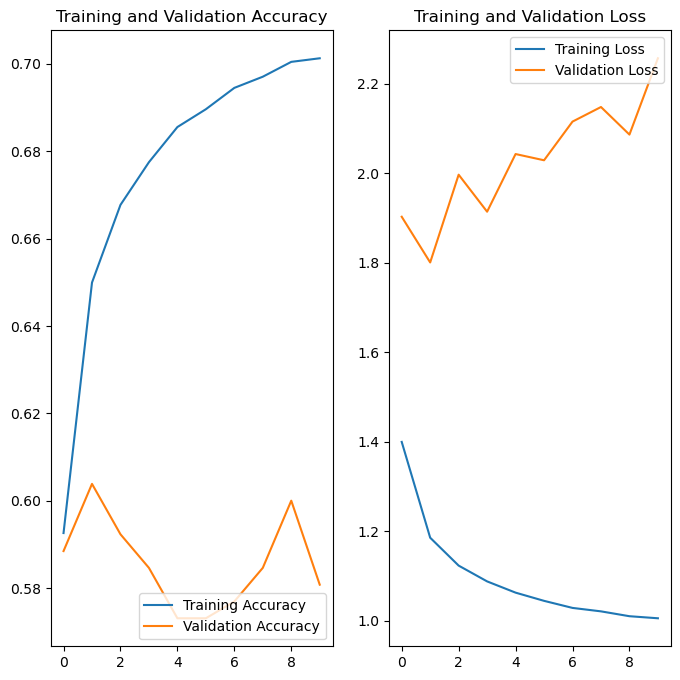

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

the results does show overfitting as the training loss does increase as the training loss decreases. It is also important to note that the peak accuracy rate of 70% is significantly lower than the 93% accuracy rate achieved with iNat training images with the same 26 species and around 213 images per species.

Even though the API images allowed a large amount of images per species, the images were not of high quality (resized from 75x75). Hence, it could be hypothesised that the degraded performance could be linked to the choice of quantity over quality.

#Training with Augmented dataset
Documentation used: [Keras guide to cutmix, mixup and randaugment](https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/), [Keras preprocessing layer documentation](https://keras.io/api/keras_cv/layers/preprocessing/).

##Variable setup

In [ ]:
IMAGE_SIZE = (img_width, img_height)
num_classes = len(class_names)
BATCH_SIZE = batch_size

In [ ]:
# instantiate keras randAugment function
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)

# function to convert tf.dataset to a dictionary type
# this is needed because keras can only peform cutmix and mixup augmentations in this type
def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}

# function to visualise sample images from a tf.dataset type dataset
def visualise_ds(ds):
  plt.figure(figsize=(10, 10))
  for images, labels in ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

#apply RandAugment image augmentation to an image in a tf.dataset
def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

# function to visualise sample images from a tf.dataset that has be converted into a dictionary type
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# function to preprocess a dataset of a dictionary type
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

# prepare resnet50 model for transfer learning and also apply label_smoothing
def get_model():
    model = keras_cv.models.ImageClassifier.from_preset(
        "efficientnetv2_s", num_classes=num_classes
    )
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=keras.optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )
    return model

##Applying image augmentations

Dataset before augmentation


2024-07-15 17:58:00.795959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-15 17:58:01.468069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


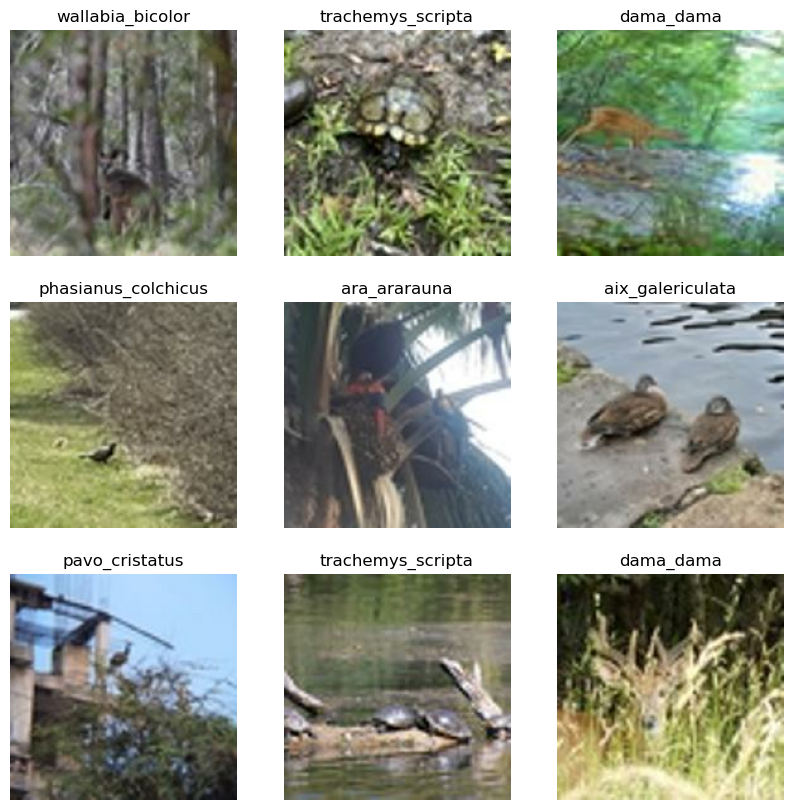

In [ ]:
# visualising normal training dataset

print("Dataset before augmentation")
visualise_ds(train_ds)

In [ ]:
# Apply randaugment to training dataset
train_ds.shuffle(10*BATCH_SIZE).map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
aug_ds = train_ds.map((lambda x, y: (rand_augment(x), y)))

Dataset after Randaugment


2024-07-15 17:58:11.871165: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-15 17:58:12.150765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


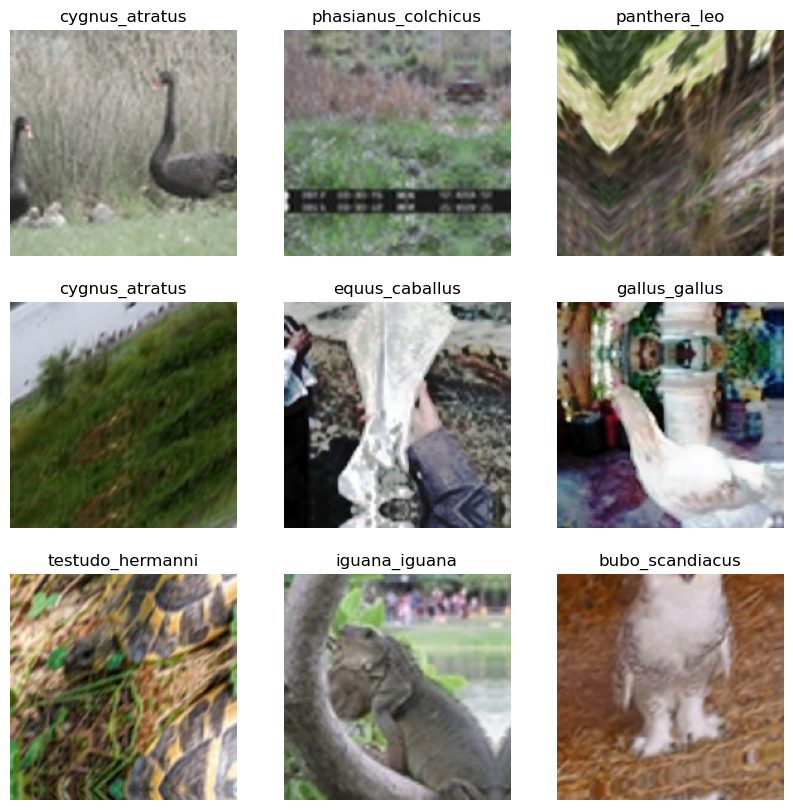

In [ ]:
# visualise augmented dataset
print("Dataset after Randaugment")
visualise_ds(aug_ds)

In [ ]:
# apply cutmix and mixup augmentation to already augmented dataset

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()
aug_ds = aug_ds.map(to_dict)
aug_ds = aug_ds.map(cut_mix)
aug_ds = aug_ds.map(mix_up)

2024-07-15 17:58:17.145436: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-15 17:58:17.149631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


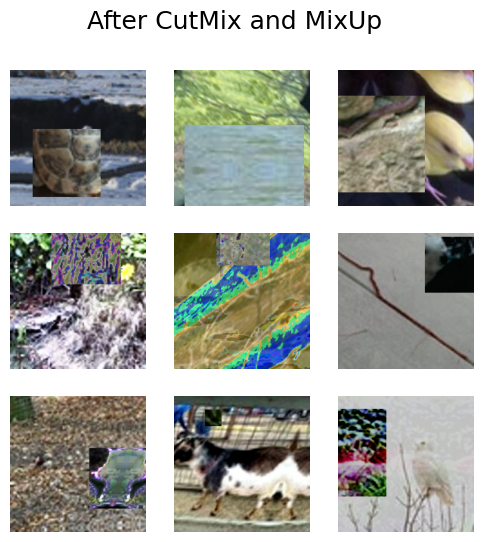

In [ ]:
# visualise augmented dataset with cutmix and mixup

visualize_dataset(aug_ds, title="After CutMix and MixUp")

In [ ]:
# prepare validation dataset

val_ds = val_ds.map(to_dict)
aug_ds = aug_ds.map(preprocess_for_model)
val_ds = val_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

##Train model

In [ ]:
input_shape = IMAGE_SIZE + (3,)

model = get_model()
model.summary()

Model: "image_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficient_net_v2_backbone   (None, None, None, 1280   20331360  
 (EfficientNetV2Backbone)    )                                   
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 predictions (Dense)         (None, 26)                33306     
                                                                 
Total params: 20364666 (77.69 MB)
Trainable params: 20210794 (77.10 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


In [ ]:
epochs = 10
history = model.fit(
    aug_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
3888/3888 [==============================] - 4532s 1s/step - loss: 3.2570 - accuracy: 0.0525 - val_loss: 3.2142 - val_accuracy: 0.0846
Epoch 2/10
3888/3888 [==============================] - 4465s 1s/step - loss: 3.2023 - accuracy: 0.0788 - val_loss: 3.2352 - val_accuracy: 0.0885
Epoch 3/10
3888/3888 [==============================] - 4444s 1s/step - loss: 3.1709 - accuracy: 0.0944 - val_loss: 3.1569 - val_accuracy: 0.1154
Epoch 4/10
3888/3888 [==============================] - 4463s 1s/step - loss: 3.1378 - accuracy: 0.1147 - val_loss: 3.0345 - val_accuracy: 0.1192
Epoch 5/10
3888/3888 [==============================] - 4453s 1s/step - loss: 3.1048 - accuracy: 0.1315 - val_loss: 2.9701 - val_accuracy: 0.2000
Epoch 6/10
3888/3888 [==============================] - 4457s 1s/step - loss: 3.0796 - accuracy: 0.1459 - val_loss: 2.8469 - val_accuracy: 0.1962
Epoch 7/10
3888/3888 [==============================] - 4468s 1s/step - loss: 3.0425 - accuracy: 0.1657 - val_loss: 2.7650 -

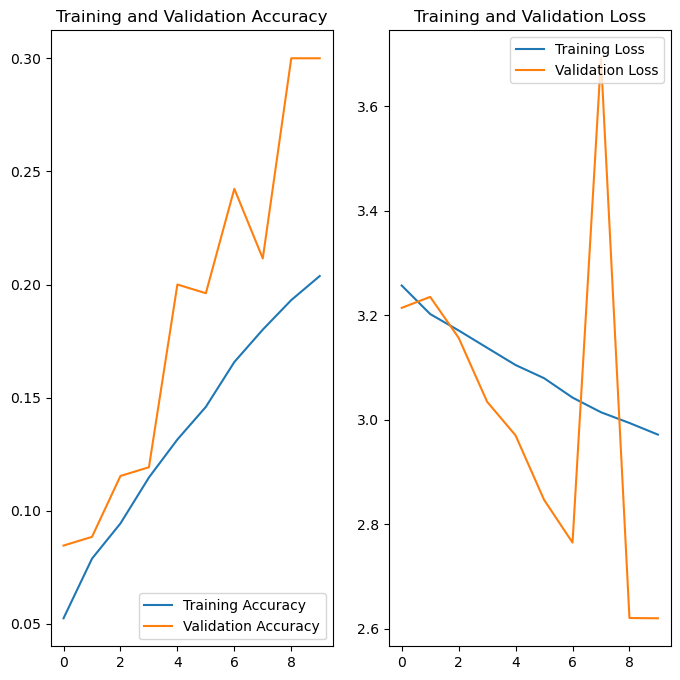

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The results are peculiar. The accuracy rates are really low, however it is interesting to note that the validation loss decreased in a similar way to the training loss but at a more impactful rate. It is also important to note that the validation and training loss is lower than the rates when training with the augmented iNat dataset.

I think that the low accuracy rates could be attributed to how unrealistic these preprocess augmentations look, which could help indicate that more experimentation into different augmentations could help. As we have seen in the past that augmentations such as dropout and random rotations have helped increase accuracy rates.

It is good to note that it was a challenge to run this notebook as SageMaker AWS log in authentication expires around 8 or so hours, making training incomplete.

This notebook production (with multiple runs) took around [$136.90 USD](https://aws.amazon.com/sagemaker/pricing/) to produce with AWS SageMaker. This notebook takes around 28 hours for one complete run.


##TensorFlow Lite Conversion
This takes the pervious model and converts it to be TensorFlow Lite.

In [ ]:
model.save('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)


##TensorFlow Lite Optimisation 
This ensures that the data is fit for the use of mobile devices, at the moment the final part of this code is experimental and may need to be changed.

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('my_model_optimized.tflite', 'wb') as f:
    f.write(tflite_model)

converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
with open('my_model_float16.tflite', 'wb') as f:
    f.write(tflite_model)